# Sampling Efficiency and Throughput
Investigating sample success rate as a product of network size.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from time import time
from labm8 import fs
from labm8 import system
from labm8.time import nowstr

import clgen
from clgen import corpus
from clgen import dbutil
from clgen import sampler
from clgen import model
from clgen import preprocess

**Experimental setup:**

In [2]:
rnn_sizes = [256, 512, 1024, 2048]
corpus_opts = {
    "path": "~/data/github"
}
training_opts = {
    "model_type": "lstm",
    "num_layers": 3,
    "max_epochs": 10
}
s = sampler.from_json({
    "kernels": {
        "args": [
            "__global float*",
            "__global float*",
            "__global float*",
            "const int"
        ],
        "max_length": 5000,
        "temperature": 1
    },
    "sampler": {
        "batch_size": 5000,
        "max_batches": 1,
        "static_checker": False,
        "dynamic_checker": False
    }
})

c = corpus.Corpus.from_json(corpus_opts)
print("Corpus size:", c.size)
print("Vocab size: ", c.vocab_size)
print()
clgen.platform_info()

Corpus size: 773245
Vocab size:  92

CLgen:      0.2.1 (with CUDA)
Platform:   Linux
Memory:     32057 MB

Device:     GPU GeForce GTX 1080
Compute #.: 20
Frequency:  1733 HZ
Memory:     8113 MB
Driver:     367.57

Device:     GPU GeForce GTX 1080
Compute #.: 20
Frequency:  1733 HZ
Memory:     8113 MB
Driver:     367.57


**Experimental methodology:**

In [3]:
def evaluate(model, sampler):
    """ evaluate sampling efficiency """
    model.cache.empty()  # clear checkpoint cache    
    tstart = time()  # start timer
    model.train(quiet=True)  # train model
    training_time = time() - tstart

    # clear the sample cache
    sampler.cache(model).empty()

    # sample kernels and time
    tstart = time()
    sampler.sample(model, quiet=True)
    tend = time()
    elapsed = tend - tstart

    # preprocess sample
    sample_db = sampler.cache(model)["kernels.db"]
    preprocess.preprocess_db(sample_db)

    num_kernels = dbutil.num_rows_in(sample_db, "ContentFiles")
    num_good_kernels = dbutil.num_good_kernels(sample_db)
    num_ugly_kernels = dbutil.num_rows_in(sample_db, "PreprocessedFiles",
                                          "WHERE status=2")
    discard_rate = 1 - (num_good_kernels / num_kernels)
    ugly_rate = 1 - (num_ugly_kernels / num_kernels)


    total_charcount = dbutil.cc(sample_db, "ContentFiles")
    good_charcount = dbutil.cc(sample_db, "PreprocessedFiles",
                               condition="WHERE status=0")

    efficiency = good_charcount / total_charcount
    throughput = good_charcount / elapsed

    return {
        "training_time": training_time,
        "sampling_time": elapsed,
        "num_kernels": num_kernels,
        "num_good_kernels": num_good_kernels,
        "discard_rate": discard_rate,
        "ugly_rate": ugly_rate,
        "total_charcount": total_charcount,
        "good_charcount": good_charcount,
        "efficiency": efficiency,  # good_chars / total_chars
        "throughput": throughput,  # good_chars / second
        "corpus_dir": model.corpus.cache.path,
        "model_dir": model.cache.path,
        "sampler_dir": sampler.cache(model).path,
    }

**Experimental results:**

In [18]:
data_file = "./sampling-{host}.json".format(host=system.HOSTNAME)
# fs.rm(data_file)  # reset experimental data
data = clgen.load_json_file(data_file, must_exist=False)

for rnn_size in rnn_sizes:
    key = str(rnn_size)
    if key not in data:
        print("collecting result for", rnn_size, "...")
        training_opts["rnn_size"] = rnn_size
        m = model.from_json({
            "corpus": corpus_opts,
            "train_opts": training_opts
        })
        data[key] = evaluate(m, s)
    print("result", rnn_size, clgen.format_json(data[key]))
    clgen.write_file(data_file, clgen.format_json(data))
print("done", nowstr())

collecting result for 4 ...
sample batch 1 ...


Number of content files:            50

Number of unique content files:     50 (100%)
Total content line count:           85
Content file line counts:           min: 1, med: 2, avg: 2, max: 3

Number of good preprocessed files:  0 (0%)
Lines of good preprocessed code:    0 (0%)
Good preprocessed line counts:      min: 0, med: 0, avg: 0, max: 0

result 4 {
  "corpus_dir": "/home/cec/.cache/clgen/0.2.1/corpus/6b4248154caa140665461619e4d1292eeee1b225",
  "discard_rate": 1.0,
  "efficiency": 0.0,
  "good_charcount": 0,
  "model_dir": "/home/cec/.cache/clgen/0.2.1/model/2ebbde31f602394dc5a7a1725da28e2a8cc8c0b1",
  "num_good_kernels": 0,
  "num_kernels": 50,
  "sampler_dir": "/home/cec/.cache/clgen/0.2.1/sampler/5def5c3571b88edaab82bf7203ec80ea3fa7ec63",
  "sampling_time": 16.92938232421875,
  "throughput": 0.0,
  "total_charcount": 4944,
  "training_time": 30.212465524673462,
  "ugly_rate": 0.98
}
collecting result for 8 ...


Process ForkPoolWorker-163:
Process ForkPoolWorker-165:
Process ForkPoolWorker-164:
Process ForkPoolWorker-166:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queu

KeyboardInterrupt: 

**Experimental results:**

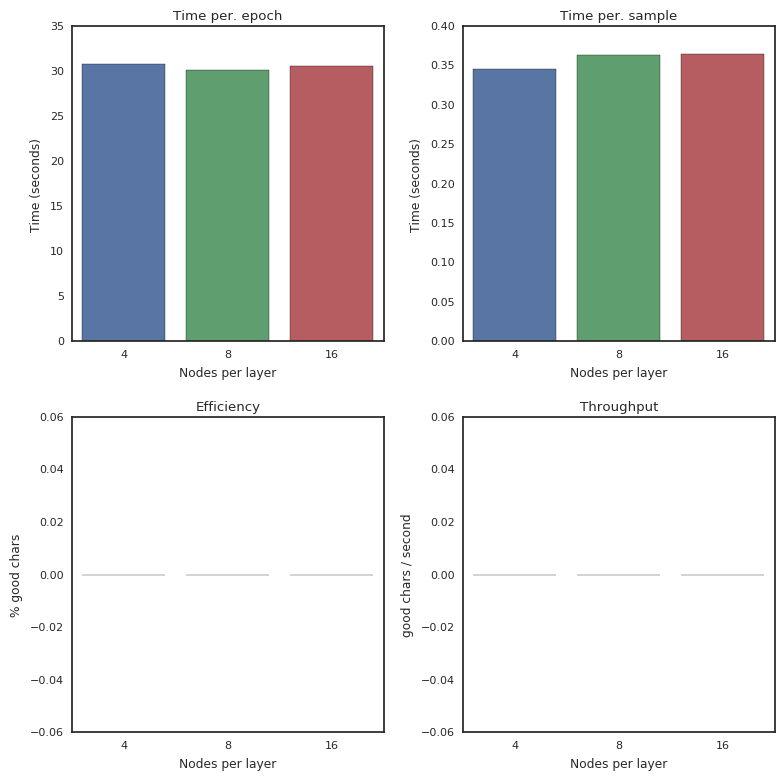

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
plt.style.use(["seaborn-white", "seaborn-paper"])

plt.subplots(2, 2)

plt.subplot(2, 2, 1)
x, y = zip(*[(int(x), data[x]["training_time"] / training_opts["max_epochs"])
             for x in sorted(data.keys(), key=lambda x: int(x))])
sns.barplot(x, y)
plt.title("Time per. epoch")
plt.xlabel("Nodes per layer")
plt.ylabel("Time (seconds)")

plt.subplot(2, 2, 2)
x, y = zip(*[(int(x), data[x]["sampling_time"] / data[x]["num_kernels"])
             for x in sorted(data.keys(), key=lambda x: int(x))])
sns.barplot(x, y)
plt.title("Time per. sample")
plt.xlabel("Nodes per layer")
plt.ylabel("Time (seconds)")
    
plt.subplot(2, 2, 3)
x, y = zip(*[(int(x), data[x]["efficiency"] * 100)
             for x in sorted(data.keys(), key=lambda x: int(x))])
sns.barplot(x, y)
plt.title("Efficiency")
plt.xlabel("Nodes per layer")
plt.ylabel("% good chars")
    
plt.subplot(2, 2, 4)
x, y = zip(*[(int(x), data[x]["throughput"])
             for x in sorted(data.keys(), key=lambda x: int(x))])
sns.barplot(x, y)
plt.title("Throughput")
plt.xlabel("Nodes per layer")
plt.ylabel("good chars / second")

viz.finalise(figsize=(8, 8))